# Medical Image Classification Tutorial with the MedNIST Dataset

In this tutorial, we'll demonstrate an end-to-end training and evaluation example of a classification task on the MedNIST dataset:

![Example images](image.png)

For ease of computation we will do this on a 2D dataset, but the pipeline can also easily generalize to 3D. We will be using [DenseNet](https://arxiv.org/abs/1608.06993), a well-tested convolutional network used in a wide variety of tasks.

This tutorial is adapted from the MONAI 2d classification tutorial. The original can be found [here](https://github.com/Project-MONAI/tutorials/blob/main/2d_classification/mednist_tutorial.ipynb).

We'll go through the following steps:
* Create a dataset for training and testing
* Use MONAI transforms to pre-process data
* Use the DenseNet121 architecture for classification
* Train the model with a standard PyTorch pipeline
* Evaluate on a held-out test dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vicory/ors-tutorial/blob/master/mednist_tutorial.ipynb)

## Setup environment
This will install the necessary python packages if they are not already present

In [18]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports
Import the packages necessary to load, process, and display the data

In [19]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.2.dev2301
Numpy version: 1.21.6
Pytorch version: 1.13.0+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: bd2e08c2ab5130e3ed58f1cdd6b864f98add2c89
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.0+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Setup data directory

This is the directory where we will download and store the data. 

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
If not specified a temporary directory will be used.

In [20]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmprs10n9j3


## Download dataset

The MedNIST dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

In [21]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:13, 4.60MB/s]                            

2023-01-04 16:01:48,923 - INFO - Downloaded: /tmp/tmprs10n9j3/MedNIST.tar.gz
2023-01-04 16:01:49,041 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-01-04 16:01:49,045 - INFO - Writing into directory: /tmp/tmprs10n9j3.


## Set deterministic training for reproducibility

This sets the seed used for all of the random initializations/etc to allow specific results to be reproduced in the future or by others

In [22]:
set_determinism(seed=0)

## Read image filenames from the dataset folders

First of all, check the dataset files and show some statistics.  
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,  
which are the labels we will use to train our classification model.

In [23]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check

We do this to examine the data, verify that the data isn't corrupt, and that the labels look correct

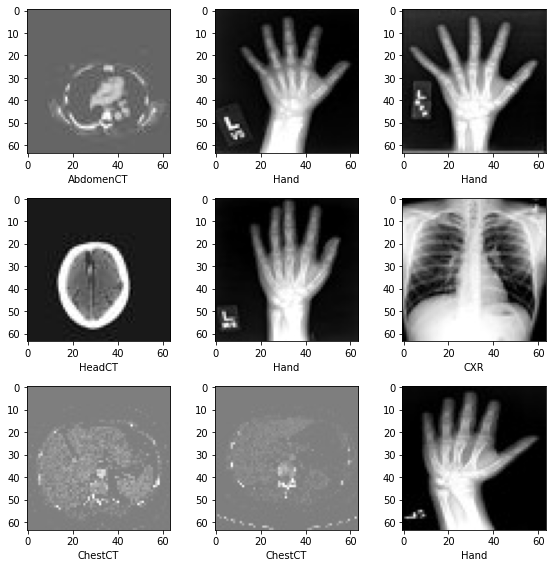

In [24]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation and test data lists

Randomly select 10% of the dataset as validation and 10% as test, leaving 80% of the data for training the model.

The validation set is used to evaluate model performance during training and parameter tuning. The test set is a held-out set used to provide an unbiased evaluation of the final model performance.

In [25]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


## Define MONAI transforms

The transforms include standard normalizations such as rescaling intensities as well as random rotoations, flips, and zooms on the training set for data augmentation.

In [26]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

## Define MONAI Dataset and Dataloader to load and process data

We create separate datasets for the training, validation, and testing data. These are MONAI datastructures that automatically load and apply the appropriate transforms to the data.

In [27]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(
    train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(
    val_ds, batch_size=300, num_workers=10)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(
    test_ds, batch_size=300, num_workers=10)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Define network and optimizer

This sets up some parametesr which control parts of the network. Some of these will be adjusted during hyperparameter tuning when trying to fine-tune a model.

1. Set learning rate which controls how much the model is updated per batch.
1. Set total epoch number, which defines how many training iterations we will go through. As this is just a tutorial, we'll just train for 4 epochs.  
1. Use DenseNet121 architecture from MONAI, which is a standard classification architecture, and move to GPU device. DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1,
                    out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

## Model training

Execute a typical PyTorch training pipeline that does validation after every epoch.  
Model weights are saved to a file if it is the best model so far.

In [29]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/157, train_loss: 1.7976
2/157, train_loss: 1.7580
3/157, train_loss: 1.7292
4/157, train_loss: 1.7115
5/157, train_loss: 1.6588
6/157, train_loss: 1.6591
7/157, train_loss: 1.6266
8/157, train_loss: 1.5755
9/157, train_loss: 1.5779
10/157, train_loss: 1.5562
11/157, train_loss: 1.5138
12/157, train_loss: 1.4980
13/157, train_loss: 1.4982
14/157, train_loss: 1.4816
15/157, train_loss: 1.4464
16/157, train_loss: 1.4336
17/157, train_loss: 1.4066
18/157, train_loss: 1.3819
19/157, train_loss: 1.3354
20/157, train_loss: 1.3218
21/157, train_loss: 1.3373
22/157, train_loss: 1.3028
23/157, train_loss: 1.2931
24/157, train_loss: 1.3035
25/157, train_loss: 1.2465
26/157, train_loss: 1.2269
27/157, train_loss: 1.1895
28/157, train_loss: 1.2007
29/157, train_loss: 1.1783
30/157, train_loss: 1.1397
31/157, train_loss: 1.1716
32/157, train_loss: 1.1186
33/157, train_loss: 1.1351
34/157, train_loss: 1.1073
35/157, train_loss: 1.1115
36/157, train_loss: 1.0816
37/157, train_lo

## Plot the loss and AUC metric

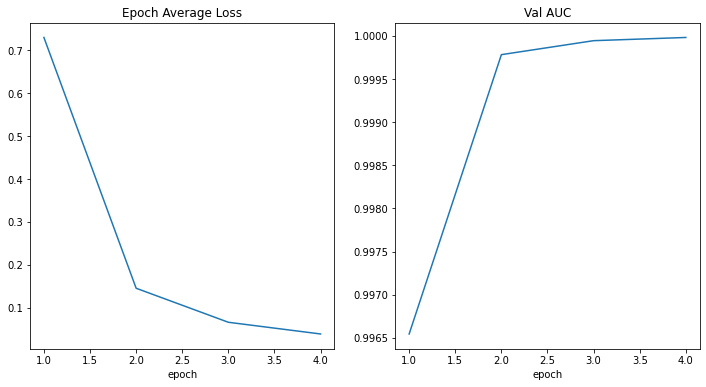

In [30]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset

After training and validation, we have the best model for the validation set.  
We then need to evaluate the model on a separate test dataset to check whether it's robust and not over-fitting.  
We'll use these predictions to generate a classification report.

In [31]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [32]:
print(classification_report(
    y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9930    0.9950    0.9940       995
   BreastMRI     0.9989    0.9920    0.9954       880
         CXR     1.0000    0.9990    0.9995       982
     ChestCT     0.9931    1.0000    0.9966      1014
        Hand     0.9990    0.9952    0.9971      1048
      HeadCT     0.9939    0.9959    0.9949       976

    accuracy                         0.9963      5895
   macro avg     0.9963    0.9962    0.9962      5895
weighted avg     0.9963    0.9963    0.9963      5895



## Cleanup data directory

Remove directory if a temporary was used.

In [33]:
if directory is None:
    shutil.rmtree(root_dir)